# II - Analyse, visualisation et feature engineering.

Cette deuxième partie se concentre sur l'analyse et la visualisation des données obtenues, ainsi que sur une construction de nouvelles variables pertinentes. Il est à noté qu'une dimension "feature engineering" était déjà présente dans la partie Récupération des données. Cependant, cette première construction de variable était nécessaire dans cette partie puisqu'il en allait davantage de "data engineering" plutôt que de data science à proprement parlé.

Nous débutons cette partie par une section donnant les principales statistiques descriptives sur notre data frame de travail.

## II.1 - Statistiques descriptives des variables d'intérêts et nettoyage des données :


On rappelle brièvement les variables présente dans le data frame de travail, récupéré 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

## II.2 - Etude des corrélations potentielles entre variable explicatives et variable cible ; visualisation : 

In [2]:
#Récupération du data frame de travail
from data.load_idf_10_24 import load_base
data = load_base()

Data Frame idf_10_24 récupéré depuis S3


In [5]:
#Construction de la variable cible "radié"
data["dateRadiation"] = pd.to_datetime(data["dateRadiation"],errors="coerce")
data["radié"] = data["dateRadiation"].notna().astype(int)

In [18]:
#Pourcentage d'entreprise radié sur notre échantillon
print(round(data["radié"].sum()/data.shape[0]*100,4), "%")

29.8777 %


### Le département à t-il un impact sur le nombre d'entreprises radiées en son sein ?

Visualisons d'abord le % d'entreprise radiée par département évalué sur l'ensemble de l'échantillon, puis celui relatif au nombre d'entreprise au sein d'un département pour corriger des effets "tailles". Nous raisonnons d'abord sur l'ensemble de la période 2010-2024.

In [20]:
#Récupération des départements 
data["cp"] = data["code_postal"].apply(lambda x : x[0:2])

In [23]:
data["cp"]

0         91
1         78
2         95
3         95
4         75
          ..
176458    94
176459    92
176460    78
176461    78
176462    78
Name: cp, Length: 176463, dtype: object

In [52]:
#Nombre d'entreprise radié par département; nombre d'entreprise par département disponibles
rad_dep = data.loc[data["radié"] == 1].groupby("cp").size().reset_index(name="nb_radié")
total_dep = data.groupby("cp").size().reset_index(name="nb_firme/dep")
df_plot_dep = total_dep.merge(rad_dep, on = "cp", how="left")
df_plot_dep["nb_firme/total"] = data.shape[0]

In [ ]:
#Pourcentage d'entreprise radiées par departement en % du total
df_plot_dep["pct_total"] = df_plot_dep["nb_radié"]/df_plot_dep["nb_firme/total"]

#Pourcentage d'entreprise radiées par dep en % par département
df_plot_dep["pct_relatif"] = df_plot_dep["nb_radié"]/df_plot_dep["nb_firme/dep"]

On remarque qu'il y a globalement un effet taille et qu'il est plus pertinent de raisonner en % non du total mais du nombre de firme dans chaque département. 

La Seine-Saint-Denis arrive en pôle position du nombre d'entreprise radiée, avec environ 37% d'entreprise radiées sur la période. Il y a équivalence entre le 77, 91; 92 et 94, pour environ 33% d'entreprises radiées.

Les Yvelines et le Val-d'Oise sont moins touchés : 28% et 30% environ. Paris remporte la compétition des entreprises les moins radiées sur la période total, avec seulement 22% d'entreprises radiées sur l'ensemble de la période.

Ainsi sur la période global, il semble se dessiner des hétérogénéité entre département sur le nombre d'entreprises radiées.

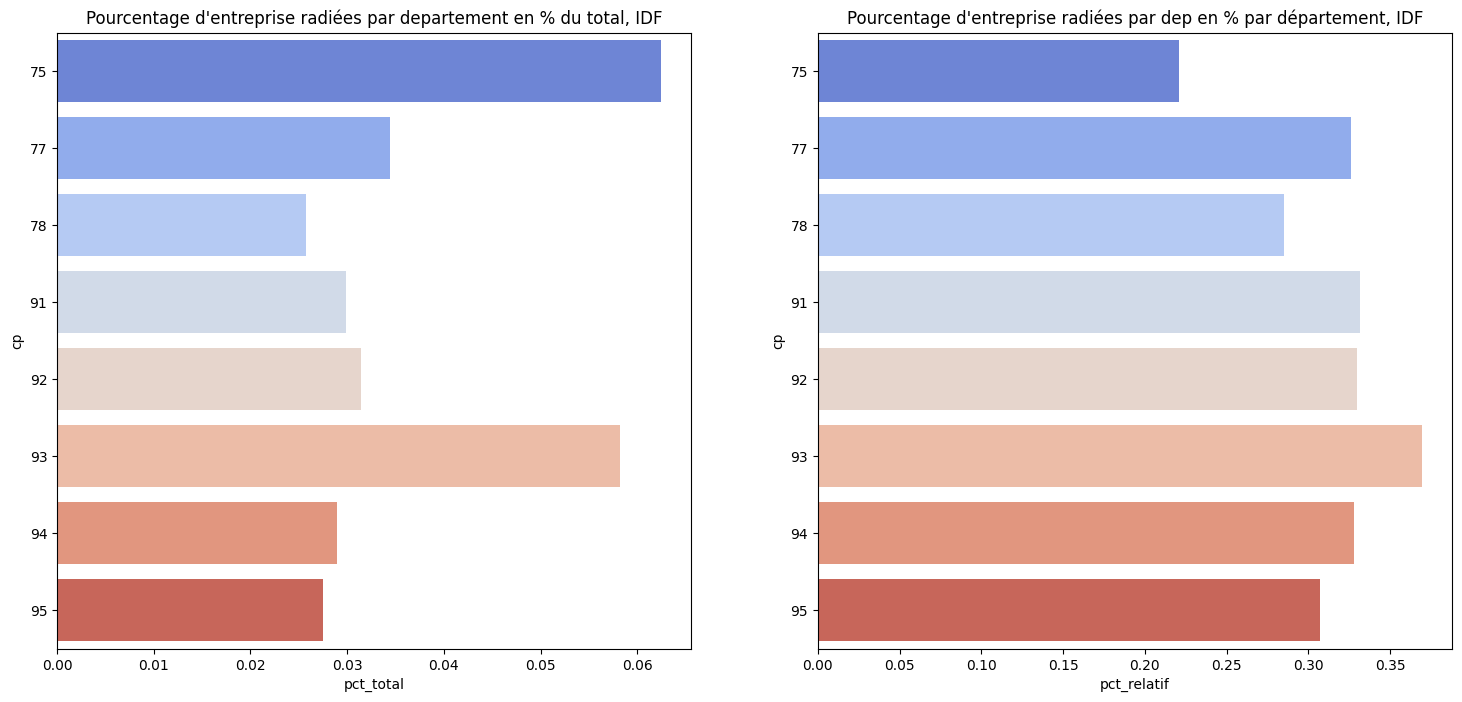

In [62]:
fig, ax = plt.subplots(1,2,figsize=(18,8))
sns.barplot(x = "pct_total", y= "cp", hue = "cp", data=df_plot_dep, palette="coolwarm", ax = ax[0])
ax[0].set_title("Pourcentage d'entreprise radiées par departement en % du total, IDF")

sns.barplot(x = "pct_relatif", y= "cp", hue="cp",data=df_plot_dep,palette="coolwarm", ax = ax[1])
ax[1].set_title("Pourcentage d'entreprise radiées par dep en % par département, IDF")
plt.show()

In [64]:
df_plot_dep[["cp","pct_relatif"]]

,cp,pct_relatif
0,75,0.220753
1,77,0.326057
2,78,0.285132
3,91,0.331637
4,92,0.329906
5,93,0.369465
6,94,0.328201
7,95,0.307108


On vérifie que cette hétérogénéité se confirme pour chaque année présente dans notre data frame de travail :

In [ ]:
#Récupération du nb d'entreprise radié par année depuis 2010
annee = [i for i in range(2010,2024)]
df_plot_dep_year = list()
for i in range(len(annee)) : 
    y_inf = annee[i]
    y_sup = an
    y_name = f"nb_rad_{y}"
    df_it = data.loc[(data["dateRadiation"].dt.year == y) & (~data["dateRadiation"].isna())].groupby("cp").size().reset_index(name = y_name)
    df_plot_dep_year.append(df_it)


In [111]:
df_plot_dep_year[0]

,cp,nb_rad_2010
0,75,9
1,77,6
2,78,3
3,91,2
4,92,2
5,93,10
6,94,5
7,95,7


In [75]:
#Groupby par année
year = data.loc[data["radié"] == 1].groupby(["cp","year"]).size().reset_index(name="nb_radié_year")

In [79]:
year.loc[year["cp"]=="93"]

,cp,year,nb_radié_year
70,93,2010,394
71,93,2011,360
72,93,2012,453
73,93,2013,460
74,93,2014,582
75,93,2015,705
76,93,2016,1010
77,93,2017,1178
78,93,2018,1195
79,93,2019,1204


## II.3 - Construction de nouvelles variables; visualisation :